In [2]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import sys
import pandas as pd
import imageio
# sys.path.append("C:\\users\\mccar\\miniconda3\\lib\\site-packages")

# from keras.models import Sequential
# from keras.layers import Dense, Dropout
# from keras.optimizers import Adam
# from keras.models import load_model
# from keras.utils import plot_model
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque

In [3]:
# Load the environment a get the number of actions and states
env = gym.make('LunarLander-v2')
env.reset()
print(env.observation_space.shape)
print(env.action_space.n)

(8,)
4


Episode finished after 113 timesteps


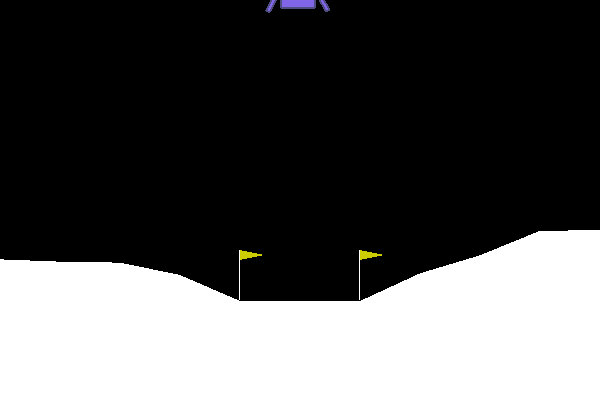

In [4]:
"""
Agent here just takes random actions and we will show the results in gif form
"""
frames = []

for i_episode in range(1):
    
    observation = env.reset()
    for t in range(200):
        # show the lander
        # env.render()
        frames.append(env.render(mode='rgb_array'))
        #print(observation)
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

gif_path = './lunar_lander.gif'
imageio.mimsave(gif_path, frames, duration=20)

from IPython.display import HTML, Image
# HTML('<img src="./project2_random_action.gif">')
# Display the GIF
Image(filename=gif_path)

In [5]:
# DQN

class DQN:
    def __init__(self, env, gamma=0.99, lr=1e-3, tau=1e-3):
        # set the environment
        self.env = env
        
        # Initialize the replay buffer
        self.replay_buffer = deque(maxlen=int(1e5))
        
        # discount factor gamma
        self.gamma = gamma
        # learning rate
        self.lr = lr
        # soft update rate
        self.tau = tau
        
        # construct the model and the target model
        self.model = self.init_model()
        self.target_model = self.init_model()
        self.optimizer = optim.Adam(params=self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        
        # Every C steps, soft update target model
        self.C = 4
        # batch size for learning
        self.batch_size = 64
        # Counter
        self.t = 0

    def init_model(self):
        input_shape = self.env.observation_space.shape[0]
        output_shape = self.env.action_space.n
        
        model = nn.Sequential(
            nn.Linear(input_shape, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_shape)
        )
        return model

    def add_to_buffer(self, state, action, reward, new_state, done):
        self.replay_buffer.append((state, action, reward, new_state, done))

    def generate_action(self, state, eps):
        if np.random.random() < eps:
            return self.env.action_space.sample()
        state = torch.FloatTensor(state)
        with torch.no_grad():
            action = self.model(state).argmax().item()
        return action

    def train_target(self):
        for target_param, param in zip(self.target_model.parameters(), self.model.parameters()):
            target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)

    def learning(self):
        self.t = (self.t + 1) % self.C
        
        if self.t == 0:
            if len(self.replay_buffer) < self.batch_size:
                return
            
            samples = random.sample(self.replay_buffer, self.batch_size)
            states, actions, rewards, next_states, dones = zip(*samples)
            
            states = torch.FloatTensor(states)
            actions = torch.LongTensor(actions).unsqueeze(1)
            rewards = torch.FloatTensor(rewards)
            next_states = torch.FloatTensor(next_states)
            dones = torch.FloatTensor(dones)

            q_values = self.model(states).squeeze(1).gather(1, actions).squeeze(1)
            next_q_values = self.target_model(next_states).squeeze(1).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values
            
            loss = self.criterion(q_values, target_q_values.detach())
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            self.train_target()

    def save_model(self, fn):
        torch.save(self.model.state_dict(), fn)

In [6]:
# Train the DQN agent

episodes = 2000
steps = 500
epsilon_decay = 0.998
tau = 1e-3
lr = 5e-3
gamma = 0.99

def train(gamma=0.999, lr=1e-3, tau=1e-3, epsilon_decay=0.998, episodes=1501, steps=500):
    env = gym.make("LunarLander-v2")
    
    epsilon = 1.0
    epsilon_min = 0.01
    
    scores = []
    scores_window = deque(maxlen=100)
    epsilons = []

    agent = DQN(env=env, gamma=gamma, lr=lr, tau=tau)
    
    for trial in range(episodes):
        score = 0
        cur_state = env.reset().reshape(1, -1)
        epsilons.append(epsilon)

        for step in range(steps):
            action = agent.generate_action(cur_state, epsilon)
            new_state, reward, done, _ = env.step(action)
            score += reward
            new_state = new_state.reshape(1, -1)
            
            agent.add_to_buffer(cur_state, action, reward, new_state, done)
            agent.learning()
            cur_state = new_state

            if done:
                break

        scores.append(score)
        scores_window.append(score)

        epsilon *= epsilon_decay
        epsilon = max(epsilon_min, epsilon)

        print(f'\rtrial {trial}\t Mean Score: {np.mean(scores_window):.3f} \t with epsilon: {epsilon:.3f} \t gamma: {gamma}', end="")
        if trial % 100 == 0:
            print(f'\rtrial {trial}\t Mean Score: {np.mean(scores_window):.3f}')
        
        # if np.mean(scores_window) >= 200.0:
        #     agent.save_model("dqn_model.pth")
        #     print(f'\n Achieve Mean Score of 200 for past 100 trials with total {trial-100} trial!\tAverage Score: {np.mean(scores_window):.3f}')
        #     break

    if True:
        torch.save(agent.model.state_dict(), "trained_agent.pth")
    env.close()
    return scores, epsilons

In [7]:
# plot values

def plot_values(values, xlabel, ylabel, epsilons=None, title='plot', name='plot.png'):
    """
    Plot the values and include a line for the rolling mean of the last 100 values.
    If epsilons is provided, plot it on the same chart with the right y-axis and include it in the legend.
    """
    fig, ax1 = plt.subplots()
    plt.title

    # Plot the main values
    line1, = ax1.plot(np.arange(len(values)), values, label='Scores')
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    
    # Calculate the rolling mean of the last 100 values
    rolling_mean = pd.Series(values).rolling(window=100).mean()
    
    # Plot the rolling mean as a line
    line2, = ax1.plot(np.arange(len(values)), rolling_mean, color='r', linestyle='--', label='Mean Last 100')
    
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]

    # Create a second y-axis to plot epsilons if provided
    if epsilons is not None:
        ax2 = ax1.twinx()
        line3, = ax2.plot(np.arange(len(epsilons)), epsilons, color='g', linestyle='-', label='Epsilons (RHS)')
        ax2.set_ylabel('Epsilons')
        
        lines.append(line3)
        labels.append(line3.get_label())

    # Add legends
    ax1.legend(lines, labels, loc='upper left')
    plt.title(title)
    plt.savefig(name)
    plt.show()


def multi_plot_values(all_values, xlabel, ylabel, names, png_name='multi_plot.png', title='plot'):
    """
    Plot the rolling means of scores for different gammas.
    """
    fig, ax = plt.subplots()

    for values, name in zip(all_values, names):
        # Calculate the rolling mean of the last 100 values
        rolling_mean = pd.Series(values).rolling(window=100).mean()
        
        # Plot the rolling mean for the current gamma
        ax.plot(np.arange(len(values)), rolling_mean, label=f'{name}: Mean Last 100')

    plt.title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()

    plt.savefig(png_name)
    plt.show()

In [8]:
# check diff learning rates

if False:
    # Define the learning rates to loop through
    learning_rates = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
    learn_rate_names = ['1e-2', '5e-3', '1e-3', '5e-4', '1e-4']

    # Initialize lists to store scores and epsilons for each learning rate
    all_train_scores = []
    all_epsilons = []

    # Loop through each learning rate option
    for lr in learning_rates:
        # Train the DQN agent for the current learning rate
        train_scores, epsilons = train(lr=lr)
        
        # Append the scores and epsilons to the lists
        all_train_scores.append(train_scores)
        all_epsilons.append(epsilons)

    multi_plot_values(all_train_scores, 'Episodes', 'Scores', learn_rate_names, 'learning_rate_scores.png', "Learning Rate Scores")

    # Find the list item in all_train_scores with the highest end mean of last 100 runs
    max_scores_idx = np.argmax([np.mean(scores[-100:]) for scores in all_train_scores])
    # Get the corresponding train_scores and epsilons
    max_train_scores = all_train_scores[max_scores_idx]
    max_name = learn_rate_names[max_scores_idx]
    max_epsilons = all_epsilons[max_scores_idx]

    # Plot the values
    plot_values(max_train_scores, 'Episodes', 'Scores', epsilons=max_epsilons, title="Max Learning Rate - {}".format(max_name), name='max_learning_rate_scores - {}.png'.format(max_name))


In [9]:
# Check diff gamma values

if False:
    # Define the gamma to loop through
    gammas = [0.9, 0.95, 0.99, 0.995, 0.999]
    gamma_names = ['0.9', '0.95', '0.99', '0.995', '0.999']

    # Initialize lists to store scores and epsilons for each gamma
    all_train_scores = []
    all_epsilons = []

    # Loop through each gamma option
    for gamma in gammas:
        # Train the DQN agent for the current gamma
        train_scores, epsilons = train(gamma=gamma)
        
        # Append the scores and epsilons to the lists
        all_train_scores.append(train_scores)
        all_epsilons.append(epsilons)

    multi_plot_values(all_train_scores, 'Episodes', 'Scores', gamma_names, 'gamma_scores.png', "Gamma Scores")

    # Find the list item in all_train_scores with the highest end mean of last 100 runs
    max_scores_idx = np.argmax([np.mean(scores[-100:]) for scores in all_train_scores])
    # Get the corresponding train_scores and epsilons
    max_train_scores = all_train_scores[max_scores_idx]
    max_name = gamma_names[max_scores_idx]
    max_epsilons = all_epsilons[max_scores_idx]

    # Plot the values
    plot_values(max_train_scores, 'Episodes', 'Scores', epsilons=max_epsilons, title="Max Gamma - {}".format(max_name), name='max_gamma_scores - {}.png'.format(max_name))

In [10]:
# Check diff steps values

if False:
    # Define the step vals to loop through
    step_vals = [100, 300, 500, 1000, 2000]
    step_names = ['100', '300', '500', '1000', '2000']

    # Initialize lists to store scores and epsilons for each step val
    all_train_scores = []
    all_epsilons = []

    # Loop through each step option
    for steps in step_vals:
        # Train the DQN agent for the current step val
        train_scores, epsilons = train(steps=steps)
        
        # Append the scores and epsilons to the lists
        all_train_scores.append(train_scores)
        all_epsilons.append(epsilons)

    multi_plot_values(all_train_scores, 'Episodes', 'Scores', step_names, 'step_scores.png', "Step Scores")

    # Find the list item in all_train_scores with the highest end mean of last 100 runs
    max_scores_idx = np.argmax([np.mean(scores[-100:]) for scores in all_train_scores])
    # Get the corresponding train_scores and epsilons
    max_train_scores = all_train_scores[max_scores_idx]
    max_name = step_names[max_scores_idx]
    max_epsilons = all_epsilons[max_scores_idx]

    # Plot the values
    plot_values(max_train_scores, 'Episodes', 'Scores', epsilons=max_epsilons, title="Max Step - {}".format(max_name), name='max_step_scores - {}.png'.format(max_name))

In [11]:
# plot_values(train_scores, "Trials", "Scores", epsilons)

In [12]:
# train our final agent
if False:
    train_scores, epsilons = train(episodes=3000)

In [13]:
# test the trained DQN model
frames = []

def test(saved_model='trained_agent.pth'):
    env = gym.make("LunarLander-v2")
    scores = []
    agent = DQN(env=env)
    agent.model.load_state_dict(torch.load(saved_model))
    agent.model.eval()
    
    # run the trained agent 10 trials
    for trial in range(100):
        score = 0
        cur_state = env.reset().reshape(1, -1)
        for step in range(1000):
            # frames.append(env.render(mode='rgb_array'))
            with torch.no_grad():
                action = agent.model(torch.FloatTensor(cur_state)).argmax().item()
            new_state, reward, done, info = env.step(action)
            new_state = new_state.reshape(1, -1)
            score += reward
            cur_state = new_state
            if done:
                break   
        
        scores.append(score)
        print('\rtrial {}\t Score: {:.3f}'.format(trial, score))
              
    env.close()
    return scores


In [15]:
def plot_test_scores(scores, name='test_scores.png'):
    fig, ax = plt.subplots()
    ax.plot(np.arange(len(scores)), scores)
    ax.axhline(y=np.mean(scores), color='r', linestyle='--', label='Mean')
    ax.set_xlabel('Trials')
    ax.set_ylabel('Scores')
    plt.title('Test Scores')
    plt.legend()
    plt.savefig(name)
    plt.show()

trial 0	 Score: 288.828
trial 1	 Score: 280.853
trial 2	 Score: 298.654
trial 3	 Score: 275.498
trial 4	 Score: 275.603
trial 5	 Score: 301.847
trial 6	 Score: 313.382
trial 7	 Score: 279.890
trial 8	 Score: 256.924
trial 9	 Score: 273.438
trial 10	 Score: 262.518
trial 11	 Score: 300.773
trial 12	 Score: 298.666
trial 13	 Score: 246.046
trial 14	 Score: 298.119
trial 15	 Score: 275.219
trial 16	 Score: 279.523
trial 17	 Score: 269.768
trial 18	 Score: 288.715
trial 19	 Score: 292.265
trial 20	 Score: 280.143
trial 21	 Score: 278.866
trial 22	 Score: 304.726
trial 23	 Score: 300.461
trial 24	 Score: 311.259
trial 25	 Score: 314.415
trial 26	 Score: 310.766
trial 27	 Score: 307.536
trial 28	 Score: 271.383
trial 29	 Score: 266.351
trial 30	 Score: 304.849
trial 31	 Score: 268.002
trial 32	 Score: 245.837
trial 33	 Score: 306.708
trial 34	 Score: 298.414
trial 35	 Score: 269.020
trial 36	 Score: 136.858
trial 37	 Score: 292.353
trial 38	 Score: 305.782
trial 39	 Score: 299.009
trial 40	 

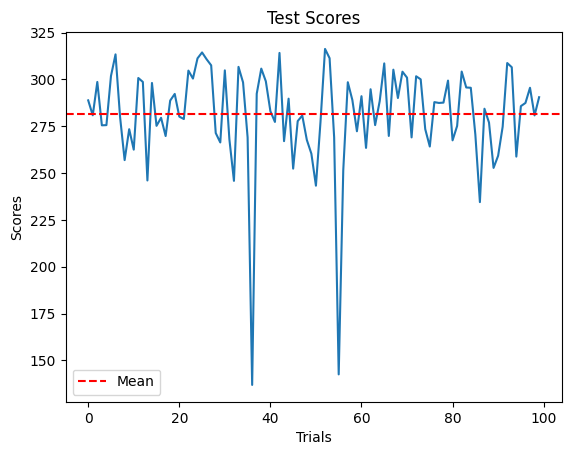

In [16]:
# test and plot
test_scores = test()
plot_test_scores(test_scores)

if False:
    gif_path = './lunar_lander_final.gif'
    imageio.mimsave(gif_path, frames, duration=20)

    from IPython.display import HTML, Image
    # HTML('<img src="./project2_random_action.gif">')
    # Display the GIF
    Image(filename=gif_path)


In [ ]:
# Function for testing with the trained DQN model
frames = []

def test(saved_model):    
    
    # Keras load trained agent
    model = load_model(saved_model)
    
    # summary of the value-action model Q
    model.summary()
    
    # plot model structure
    plot_model(model, show_shapes = True, to_file='model.png')
    print("model weights:", model.get_weights()) 
   
    # test the trained agent
    env = gym.make("LunarLander-v2")
    scores = []
    
    # run the trained agent 100 trials
    for trial in range(10):
        score = 0
        cur_state = env.reset().reshape(1,8)
        for step in range(1000):
            frames.append(env.render(mode='rgb_array'))
            # take action based on the best action from model Q
            action = np.argmax(model.predict(cur_state)[0])
            # get new state, reward
            new_state, reward, done, trunc, info = env.step(action)
            new_state = new_state.reshape(1,8)
            score += reward
            cur_state = new_state
            if done:
                break   
        
        scores.append(score)
        print('\rtrial {}\t Score: {:.3f}'.format(trial, (score)), end="")
              
    env.close()
    return scores

In [ ]:
# Function for testing with the trained DQN model
frames = []

def test(saved_model):    
    
    # Keras load trained agent
    model = load_model(saved_model)
    
    # summary of the value-action model Q
    model.summary()
    
    # plot model structure
    plot_model(model, show_shapes = True, to_file='model.png')
    print("model weights:", model.get_weights()) 
   
    # test the trained agent
    env = gym.make("LunarLander-v2")
    scores = []
    
    # run the trained agent 100 trials
    for trial in range(10):
        score = 0
        cur_state = env.reset().reshape(1,8)
        for step in range(1000):
            frames.append(env.render(mode='rgb_array'))
            # take action based on the best action from model Q
            action = np.argmax(model.predict(cur_state)[0])
            # get new state, reward
            new_state, reward, done, trunc, info = env.step(action)
            new_state = new_state.reshape(1,8)
            score += reward
            cur_state = new_state
            if done:
                break   
        
        scores.append(score)
        print('\rtrial {}\t Score: {:.3f}'.format(trial, (score)), end="")
              
    env.close()
    return scores

In [13]:
# test and plot
test_scores = test("dqn_model.h5")

gif_path = './lunar_lander_complete.gif'
imageio.mimsave(gif_path, frames, duration=20)

from IPython.display import HTML, Image
# HTML('<img src="./project2_random_action.gif">')
# Display the GIF
Image(filename=gif_path)

plot_values(test_scores, "Trails", "Scores")
print("Average Score of 10 trials: {:.3f}".format(np.mean(test_scores)))

plot_values(epsilons, "Trails", "Epsilons")

NameError: name 'load_model' is not defined